In [474]:
import yfinance as yf
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import helpers
import importlib
from helpers import OverNightStrategy

In [475]:
# Reload modules to avoid a kernel restart
importlib.reload(helpers);
from helpers import OverNightStrategy

In [456]:
tickers = helpers.get_all_tickers_from_dir()

In [514]:
# Or get tickers based on market cap
tickers = helpers.get_tickers_with_market_cap_limit(0.75, .95)

### Backtesting the overnight strategy with N best stocks

In [515]:
strat = OverNightStrategy(tickers, signal_sample_period_days=50)
strat.skew_factor = 2

Fetching data: 166/166, TRIAN-B.STTST
Cleaning up
Done


In [516]:
strat.compute_portfolio(number_of_stocks_in_portfolio=10, portfolio_weight_type=None)
strat.compute_portfolio_stats(print_stats=True)

Ann. return: 53.5%, Ann. std: 17.3%, Sharpe: 3.1, Beta: 0.1


(0.5353945881819666, 0.1729355072393939, 3.0959205355139825)

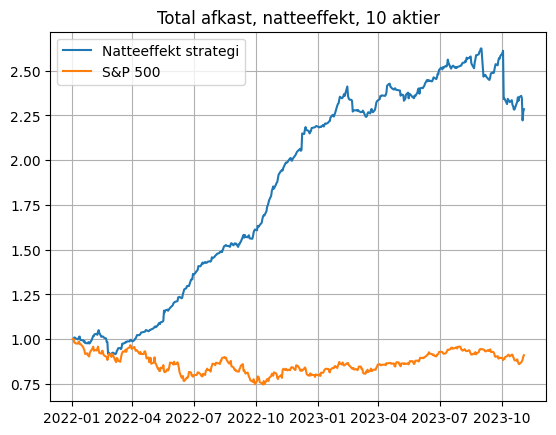

In [519]:
strat.plot_performance(start_date=dt.date(2022, 1, 1), log=False)

In [452]:
sharpes = []
for i in range(1, 60, 2):
    for j in range(1, 15):
        strat = OverNightStrategy(tickers, signal_sample_period_days=i)
        strat.compute_portfolio(number_of_stocks_in_portfolio=j, portfolio_weight_type=None)
        _, _, sharpe = strat.compute_portfolio_stats(print_stats=True)
        sharpes.append([i, j, sharpe])

Ann. return: 46.0%, Ann. std: 44.6%, Sharpe: 1.03, Beta: 0.04
Ann. return: 63.4%, Ann. std: 27.4%, Sharpe: 2.31, Beta: 0.07
Ann. return: 57.1%, Ann. std: 20.7%, Sharpe: 2.76, Beta: 0.09
Ann. return: 56.2%, Ann. std: 17.6%, Sharpe: 3.2, Beta: 0.11
Ann. return: 46.6%, Ann. std: 15.5%, Sharpe: 3.0, Beta: 0.13
Ann. return: 40.0%, Ann. std: 14.0%, Sharpe: 2.86, Beta: 0.12
Ann. return: 35.5%, Ann. std: 12.9%, Sharpe: 2.75, Beta: 0.14
Ann. return: 31.9%, Ann. std: 12.1%, Sharpe: 2.65, Beta: 0.14
Ann. return: 29.8%, Ann. std: 11.4%, Sharpe: 2.6, Beta: 0.15
Ann. return: 27.7%, Ann. std: 11.0%, Sharpe: 2.52, Beta: 0.15
Ann. return: 24.9%, Ann. std: 10.5%, Sharpe: 2.37, Beta: 0.16
Ann. return: 22.4%, Ann. std: 10.2%, Sharpe: 2.2, Beta: 0.16
Ann. return: 20.5%, Ann. std: 10.0%, Sharpe: 2.06, Beta: 0.17
Ann. return: 19.2%, Ann. std: 9.7%, Sharpe: 1.98, Beta: 0.17
Ann. return: 53.8%, Ann. std: 46.0%, Sharpe: 1.17, Beta: 0.05
Ann. return: 66.4%, Ann. std: 27.9%, Sharpe: 2.38, Beta: 0.07
Ann. return: 

In [473]:
pd.DataFrame(sharpes, columns=['sample_period', 'num_stocks', 'sharpe'])

,sample_period,num_stocks,sharpe
0,1,1,1.031638
1,1,2,2.314633
2,1,3,2.757827
3,1,4,3.202057
4,1,5,2.999202
...,...,...,...
415,59,10,2.793251
416,59,11,2.708014
417,59,12,2.663406
418,59,13,2.638485
